In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,recall_score,roc_auc_score, precision_score,f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,StratifiedKFold
import warnings


In [2]:
df=pd.read_csv('EMG-data.csv')
df.drop('time',inplace=True,axis=1)
df.head()

,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,label
0,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0,1
2,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
3,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1
4,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0,1


In [3]:
df['class'].value_counts()

0    2725157
6     253009
5     251733
4     251570
1     250055
3     249494
2     243193
7      13696
Name: class, dtype: int64

In [4]:
len(df['label'].value_counts())

36

In [5]:
subjects_data=df.groupby(['label','class'])

In [7]:
def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)


def zero_crossing(data):
    return np.argmax(np.diff(np.sign(data),axis=0),axis=0)

In [8]:
start=time()
features=subjects_data.agg([ 'min','max',np.ptp,rms,zero_crossing,abs_diffs_signal])

In [9]:
end=time()
print('feature calculation time of one subject one class')
print((end-start)/(36*7))

feature calculation time of one subject one class
0.04442822365533738


In [10]:
features=features.reset_index()
features.head()

label class channel1                                            \
                   min      max      ptp       rms zero_crossing   
0     1     0 -0.00116  0.00127  0.00243  0.000130           105   
1     1     1 -0.00005  0.00004  0.00009  0.000017           125   
2     1     2 -0.00111  0.00095  0.00206  0.000210             0   
3     1     3 -0.00087  0.00112  0.00199  0.000188            96   
4     1     4 -0.00020  0.00016  0.00036  0.000056            33   

                   channel2           ... channel7                          \
  abs_diffs_signal      min      max  ...      ptp       rms zero_crossing   
0          0.68856 -0.00108  0.00127  ...  0.00236  0.000122            38   
1          0.01070 -0.00010  0.00007  ...  0.00006  0.000013             8   
2          0.16819 -0.00047  0.00041  ...  0.00153  0.000216            58   
3          0.14544 -0.00113  0.00127  ...  0.00063  0.000078            24   
4          0.03609 -0.00038  0.00024  ...  0.00090  0.000118            32   

                   channel8                                            \
  abs_diffs_signal      min      max      ptp       rms zero_crossing   
0          0.65928 -0.00098  0.00127  0.00225  0.000134             1   
1          0.00870 -0.00005  0.00002  0.00007  0.000014            67   
2          0.16251 -0.00070  0.00054  0.00124  0.000150             0   
3          0.05866 -0.00073  0.00051  0.00124  0.000161            24   
4          0.07517 -0.00032  0.00026  0.00058  0.000083            55   

                    
  abs_diffs_signal  
0          0.71288  
1          0.00921  
2          0.11696  
3          0.11869  
4          0.04984  

[5 rows x 50 columns]

In [13]:
classifiers = [
    KNeighborsClassifier(metric='manhattan',weights='distance',n_neighbors=4),
    SVC(C=3, gamma=0.04), 
    DecisionTreeClassifier(criterion= 'entropy',max_depth= 7,max_features= 'auto',random_state= 20),
    RandomForestClassifier(bootstrap=False,max_depth=8,max_features='sqrt',min_samples_leaf=1,
                          min_samples_split=2,n_estimators=100),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(C=0.05, penalty='l2')]

In [16]:
warnings.filterwarnings('always') 
clf_performace={'accuracy':[],'f1score':[],'training_time':[],'testing_time':[]}
for clfs in classifiers:
    #pipeline.set_params(estimator = clfs)
    name = clfs.__class__.__name__
    accuracy=[]
    f1score=[]
    recall=[]
    precision=[]
    training_time=[]
    testing_time=[]
    for i in range(1,37):
        train=features[features['label']!=i]
        test=features[features['label']==i]
        X_train=train.iloc[:,2::].values
        X_test=test.iloc[:,2::].values
        y_train=train['class']
        y_test=test['class']
        training_start=time()
        clf = make_pipeline(StandardScaler(), clfs)
        clf.fit(X_train, y_train)
        training_end=time()
        testing_start=time()
        y_pred=clf.predict(X_test)
        testing_end=time()
        acc=accuracy_score(y_test,y_pred)
        recall.append(recall_score(y_test,y_pred,average='macro'))
        #precision.append(precision_score(y_test,y_pred,average='macro'))
        f1score.append(f1_score(y_test,y_pred,average='macro'))
        accuracy.append(acc)
        training_time.append(training_end-training_start)
        testing_time.append(testing_end-testing_start)
        #print('subject {} accuracy is {}'.format(i,acc))
    print(name,np.mean(accuracy))
    clf_performace['accuracy'].append(accuracy)
    clf_performace['f1score'].append(f1score)
    clf_performace['training_time'].append(np.mean(training_time))
    clf_performace['testing_time'].append(np.mean(testing_time))

KNeighborsClassifier 0.894345238095238
SVC 0.8983134920634921
DecisionTreeClassifier 0.7648809523809526
RandomForestClassifier 0.8506944444444444
GradientBoostingClassifier 0.8358134920634921
GaussianNB 0.8348214285714286
LinearDiscriminantAnalysis 0.8159722222222223
LogisticRegression 0.8551587301587301


In [17]:
a=np.mean(np.array(clf_performace['accuracy']),axis=1)
f=np.mean(np.array(clf_performace['f1score']),axis=1)

In [18]:
df=pd.DataFrame(np.stack((a,f)),columns=['KNN','SVM','DT','RF','GB','NB','LDA','LR'],
            index=['Accuracy','F1-score'])
df

,KNN,SVM,DT,RF,GB,NB,LDA,LR
Accuracy,0.894345,0.898313,0.764881,0.850694,0.835813,0.834821,0.815972,0.855159
F1-score,0.863757,0.869048,0.708234,0.808201,0.795734,0.791005,0.771412,0.817378


<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
/tmp/ipykernel_16959/3057351781.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('result.eps',dip=300)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


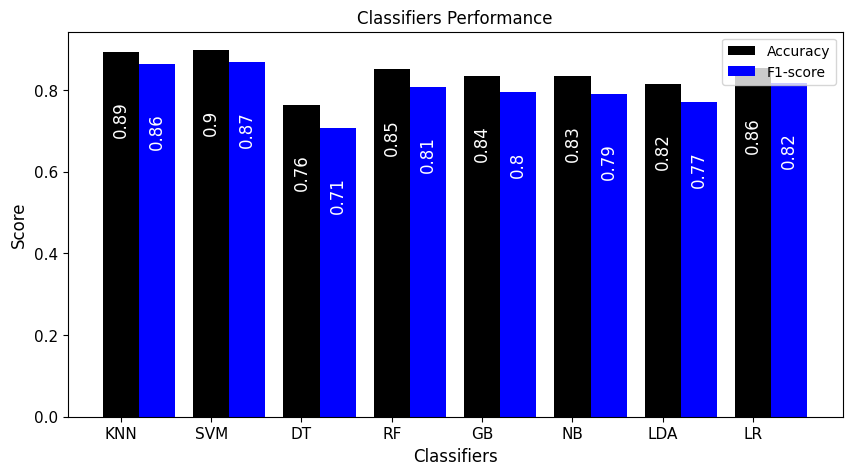

In [19]:
classifier=df.loc['F1-score'].index
y_pos = np.arange(len(classifier))
w=0.4

plt.figure(figsize=(10,5))
plt.bar(y_pos,df.loc['Accuracy'].values,align='center',width=w,label='Accuracy',color='black')
plt.bar(y_pos+w,df.loc['F1-score'].values,align='center',width=w,label='F1-score',color='blue')

ya=df.loc['Accuracy'].values
for index, value in enumerate(ya):
    plt.text(index-0.1,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=12)

yf=df.loc['F1-score'].values
for index, value in enumerate(yf):
    plt.text(index+w-0.1,value-0.2, str(np.round(value,2)),rotation=90,color='white',fontsize=12)


plt.xticks(y_pos, classifier,fontsize=11)
plt.yticks(fontsize=11)
plt.ylabel('Score',fontsize=12)
plt.xlabel('Classifiers',fontsize=12)
plt.title('Classifiers Performance',fontsize=12)
plt.legend()
plt.savefig('result.eps',dip=300)

In [20]:
pd.DataFrame(zip(np.array(clf_performace['training_time'])*65,np.array(clf_performace['testing_time'])),
            columns=['training_time','testing_time'],
            index=['KNN','SVM','DT','RF','GB','NB','LDA','LR'])

,training_time,testing_time
KNN,0.058907,0.003568
SVM,0.577025,0.000323
DT,0.234115,0.000200
RF,7.743576,0.007156
GB,123.362592,0.000816
NB,0.091240,0.000339
LDA,0.731866,0.000276
LR,1.194655,0.000212
